# Problem Statement:

Fit.ly is a subscription-based fitness app. Leadership has noticed subscriber churn is increasing, and they want answers.
I need to 
-Analyze Churn
-Identify patterns and drivers of churn (such as user engagement, Customer support Activity, subscription plan type)
-Define Business Metric
-Recommend practical actions

# 1. Loading Data

In [2322]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import chisquare
import seaborn as sns
from scipy.stats import f_oneway

In [1973]:
account_info= 'https://s3.us-east-1.amazonaws.com/talent-assets.datacamp.com/da_fitly_account_info.csv'
customer_support= 'https://s3.us-east-1.amazonaws.com/talent-assets.datacamp.com/da_fitly_customer_support.csv'
user_activity= 'https://s3.us-east-1.amazonaws.com/talent-assets.datacamp.com/da_fitly_user_activity.csv'

account_info= pd.read_csv(account_info)
customer_support= pd.read_csv(customer_support)
user_activity= pd.read_csv(user_activity)

In [1974]:
print(account_info.head())

  customer_id                  email       state        plan  plan_list_price  \
0      C10000  user10000@example.com  New Jersey  Enterprise              105   
1      C10001  user10001@example.net   Louisiana       Basic               22   
2      C10002  user10002@example.net    Oklahoma       Basic               24   
3      C10003  user10003@example.com    Michigan        Free                0   
4      C10004  user10004@example.com       Texas  Enterprise              119   

  churn_status  
0            Y  
1            Y  
2          NaN  
3          NaN  
4          NaN  


In [1975]:
print(customer_support.head())

                  ticket_time  user_id channel      topic  \
0  2025-06-13 05:55:17.154573    10125    chat  technical   
1  2025-08-06 13:21:54.539551    10109    chat    account   
2  2025-08-22 12:39:35.718663    10149    chat  technical   
3  2025-06-07 02:49:46.986055    10268   phone    account   
4  2025-07-25 00:24:38.945079    10041   phone      other   

   resolution_time_hours  state                          comments  
0                  11.48      1                               NaN  
1                   1.01      0                               NaN  
2                  10.09      0  Erase my data from your systems.  
3                   9.10      1                               NaN  
4                   2.28      1                               NaN  


In [1979]:
print(user_activity.head())

                   event_time  user_id     event_type
0  2025-09-08 15:05:39.422721    10118    watch_video
1  2025-09-08 08:15:05.264103    10220    watch_video
2  2025-11-14 06:28:35.207671    10009  share_workout
3  2025-08-20 16:53:38.682901    10227   read_article
4  2025-07-24 16:47:31.728422    10123  track_workout


**Initial Observations**:

- The datasets loaded successfully.
- Column names are not as expected
  **Account Info**
    - `plan` should be renamed to `plan_type`
    - `signup_date` appears to be missing and will require further investigation
  **Customer Support**
    - `Topic` and `State` require standardization to lowercase snake_case

- I will next perform data validation to check for:
  - Missing values
  - Incorrect data types
  - Unexpected plan types
  - Duplicate records
  - Irregular timestamps


## 2. Data Validation and Cleaning

In this section, I validate each variable in the three datasets and perform cleaning where necessary to create analysis-ready data. Given that the engineering team confirmed there is no standardisation or cleaning in the upstream pipelines, I explicitly check data types, missing values, duplicates, and inconsistent categories.


In [1983]:
# Account info
account_info.info()
account_info.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      400 non-null    object
 1   email            400 non-null    object
 2   state            400 non-null    object
 3   plan             400 non-null    object
 4   plan_list_price  400 non-null    int64 
 5   churn_status     114 non-null    object
dtypes: int64(1), object(5)
memory usage: 18.9+ KB


customer_id          0
email                0
state                0
plan                 0
plan_list_price      0
churn_status       286
dtype: int64

In [1985]:
# Customer support
customer_support.info()
customer_support.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ticket_time            918 non-null    object 
 1   user_id                918 non-null    int64  
 2   channel                918 non-null    object 
 3   topic                  918 non-null    object 
 4   resolution_time_hours  918 non-null    float64
 5   state                  918 non-null    int64  
 6   comments               46 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 50.3+ KB


ticket_time                0
user_id                    0
channel                    0
topic                      0
resolution_time_hours      0
state                      0
comments                 872
dtype: int64

In [1987]:
# User activity
user_activity.info()
user_activity.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  445 non-null    object
 1   user_id     445 non-null    int64 
 2   event_type  445 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.6+ KB


event_time    0
user_id       0
event_type    0
dtype: int64

**Account_info:**
  Churn_status is the only column with Nulls

**Customer_Support:**
    Comment is the only column with Nulls

**User_Activity:**
    No columns have Nulls

### 2.1 Validate and Cleaning for account_info ###

In [1991]:
#Rename columns for consistency
account_info = account_info.rename(columns={
    "plan": "plan_type"
})

In [1993]:
#Check missing values of User_id
account_info["customer_id"].isna().sum()

0

In [1995]:
#check type of User_id
print(account_info["customer_id"].dtype)

object


In [1997]:
#striping user_id of any white space
account_info["customer_id"] = account_info["customer_id"].str.strip()

In [1999]:
#Check uniqueness of user_id
account_info["customer_id"].nunique(), len(account_info)

(400, 400)

In [2001]:
#checking for weird characters
account_info["customer_id"].str.contains(r"[^A-Za-z0-9_-]", regex=True).sum()

0

In [2003]:
#Checking Missing values for email
account_info["email"].isna().sum()

0

In [2005]:
#Checking for bad values in email
account_info["email"].str.contains("@").value_counts(dropna=False)

email
True    400
Name: count, dtype: int64

In [2007]:
#check type of email
print(account_info["email"].dtype)

object


In [2009]:
#Removing any white spaces and making all lowercase
account_info["email"] = ( account_info["email"] .astype(str) .str.strip() .str.lower() )

In [2011]:
#Checkign for duplicates
account_info["email"].duplicated().sum()

0

In [2013]:
#Checking Missing values for state
account_info["state"].isna().sum()

0

In [2015]:
print(account_info["state"].dtype)

object


In [2017]:
#Checking for any lower/upper inconsistencies or spaces in state
account_info["state"].unique()

array(['New Jersey', 'Louisiana', 'Oklahoma', 'Michigan', 'Texas', 'Ohio',
       'Kentucky', 'North Carolina', 'Alaska', 'Virginia', 'Kansas',
       'Arizona', 'Idaho', 'Connecticut', 'Colorado', 'Rhode Island',
       'Maine', 'Wisconsin', 'Vermont', 'Florida', 'Delaware', 'New York',
       'Montana', 'Missouri', 'West Virginia', 'New Mexico', 'Iowa',
       'North Dakota', 'Hawaii', 'Nebraska', 'South Dakota', 'Utah',
       'Washington', 'Pennsylvania', 'Nevada', 'Arkansas', 'Illinois',
       'Wyoming', 'California', 'Tennessee', 'Minnesota', 'Maryland',
       'Massachusetts', 'Mississippi', 'South Carolina', 'Oregon',
       'Georgia', 'Indiana', 'Alabama', 'New Hampshire'], dtype=object)

In [2019]:
#Counting the number of states
account_info["state"].nunique()

50

In [2021]:
#Checking Missing values for plan_type
account_info["plan_type"].isna().sum()

0

In [2023]:
print(account_info["plan_type"].dtype)

object


In [2025]:
#Checking uniqiue values for plan_type
account_info["plan_type"].unique()

array(['Enterprise', 'Basic', 'Free', 'Pro'], dtype=object)

In [2027]:
#Checking Missing values for plan_list_price
account_info["plan_list_price"].isna().sum()

0

In [2029]:
#Check the plan_list_price type
print(account_info["plan_list_price"].dtype)

int64


In [2031]:
#Checking the values
account_info["plan_list_price"].describe()

count    400.000000
mean      43.965000
std       45.263348
min        0.000000
25%        0.000000
50%       26.000000
75%       77.250000
max      148.000000
Name: plan_list_price, dtype: float64

In [2033]:
#checking distribution by plan_type
account_info.groupby("plan_type")["plan_list_price"].describe()

,count,mean,std,min,25%,50%,75%,max
plan_type,,,,,,,,
Basic,118.0,19.872881,5.914702,10.0,15.0,20.0,24.0,30.0
Enterprise,92.0,116.010870,20.532737,81.0,96.5,119.0,134.0,148.0
Free,105.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Pro,85.0,53.741176,14.595460,32.0,42.0,53.0,64.0,80.0


In [2035]:
#Checking data entry issues
account_info["plan_list_price"].value_counts().sort_index()

plan_list_price
0      105
10       7
11       4
12       6
13       6
      ... 
143      1
144      2
145      2
147      2
148      1
Name: count, Length: 106, dtype: int64

In [2037]:
#Looking at the raw values
account_info["churn_status"].value_counts(dropna=False)

churn_status
NaN    286
Y      114
Name: count, dtype: int64

In [2039]:
#stripping of spaces and making lowercase
account_info["churn_status"] = (
    account_info["churn_status"]
    .astype(str)
    .str.strip()
    .str.lower()
)

In [2041]:
#Making Churn_status binary
churn_map = {
    "y": 1}

account_info["churn_status"] = account_info["churn_status"].map(churn_map)

In [2043]:
#Check the churn_status type
print(account_info["churn_status"].dtype)

float64


In [2051]:
#Changing type to int
account_info['churn_status'] = account_info['churn_status'].astype('Int64')

In [2053]:
#Check the churn_status type
print(account_info["churn_status"].dtype)

Int64


### Validation of `account_info`

**customer_id**  
The `customer_id` field contained no missing values and all entries were unique, confirming it functions properly as a primary key. The values were stored as objects, which is appropriate for an identifier. After stripping whitespace and checking for unusual characters or case inconsistencies, the field appeared clean and required no further transformation.

**email**  
The `email` field had no missing values and no duplicates, and all entries followed a valid email format. I standardized the field by converting all values to lowercase and removing any leading or trailing whitespace. No additional cleaning was necessary.

**state**  
The `state` field contained exactly 50 unique values, corresponding to the 50 U.S. states. There were no spelling inconsistencies, casing issues, or whitespace irregularities. Because the values were already standardized and complete, no further cleaning was required.

**plan_type**  
The `plan_type` field had no missing values and no spelling inconsistencies. All values were stored as objects, which is appropriate for a categorical variable. I found no whitespace or formatting issues, so the field was retained as-is.

**plan_list_price**  
The `plan_list_price` field had the correct numeric dtype and contained no negative values. When examining the distribution, I observed several high values (e.g., 143 and 148) that appeared only once. All of these belonged to the enterprise plan tier. Because enterprise pricing often varies due to negotiated contracts and custom billing arrangements, these values are plausible and not indicative of data quality issues. I therefore retained them rather than treating them as outliers.

**churn_status**  
The `churn_status` field was standardized by stripping whitespace and converting values to lowercase. The column contained 286 missing values. Based on the engineering team’s explanation that upstream systems do not perform validation or backfilling, these missing values are expected and likely reflect system gaps rather than meaningful customer behavior. Because churn is a business‑critical variable, imputing missing values (e.g., assuming they are active or churned) would introduce bias and distort churn metrics. I retained all rows but excluded those with missing churn status from analyses that require a known churn outcome, such as churn rate calculations or comparisons between churned and active users. The field remains stored as an object, which is appropriate for a categorical label.


**2.1 Validate and Clean customer_support**

In [2067]:
#Checking Missing values for ticket_time
customer_support['ticket_time'].isna().sum()

0

In [2069]:
#Check ticket_time type
print(customer_support['ticket_time'].dtype)

datetime64[ns]


In [2125]:
customer_support["ticket_time"].nunique(), len(customer_support)

(918, 918)

In [2071]:
#Convert ticket_time to datetime
customer_support["ticket_time"] = pd.to_datetime(
    customer_support["ticket_time"], errors="coerce"
)

In [2073]:
#Check Convertion worked
print(customer_support['ticket_time'].dtype)

datetime64[ns]


In [2075]:
customer_support['ticket_time'].describe()

count                              918
mean     2025-08-31 15:20:40.426390016
min         2025-06-05 15:32:33.005817
25%      2025-07-21 01:59:01.541433088
50%      2025-08-31 13:24:11.749873920
75%      2025-10-09 09:55:48.912953600
max         2025-12-01 22:01:58.485299
Name: ticket_time, dtype: object

In [2077]:
#Checking user_id for missing values
customer_support["user_id"].isna().sum()

0

In [2079]:
#check type of User_id
print(customer_support["user_id"].dtype)

int64


In [2081]:
#Check the uniqueness of user_id
customer_support["user_id"].nunique(), len(customer_support)

(367, 918)

In [2083]:
#Checking channel for missing values
customer_support["channel"].isna().sum()

0

In [2085]:
#check type of channel
print(customer_support["channel"].dtype)

object


In [2087]:
#Checking values of Channel
customer_support["channel"].unique()

array(['chat', 'phone', '-', 'email'], dtype=object)

In [2089]:
#counting the number of each value
customer_support["channel"].value_counts()

channel
email    298
chat     294
phone    287
-         39
Name: count, dtype: int64

In [2127]:
#Converting - to NaN
customer_support["channel"] = customer_support["channel"].replace("-", np.nan)

In [2129]:
#Standardizing the rest of the channels
customer_support["channel"] = (
    customer_support["channel"]
    .str.strip()
)

In [2131]:
#Checking topic for missing values
customer_support["topic"].isna().sum()

0

In [2133]:
#check type of topic
print(customer_support["topic"].dtype)

object


In [2135]:
#Checking values of topic
customer_support["topic"].unique()

array(['technical', 'account', 'other', 'billing'], dtype=object)

In [2137]:
#Strip of white space and lowercase all values
customer_support["topic"] = (
    customer_support["topic"]
    .str.strip()
)

In [2139]:
#Counting the number of each value
customer_support["topic"].value_counts().head(20)

topic
billing      239
other        228
technical    226
account      225
Name: count, dtype: int64

In [2141]:
#Checking resolution_time_hours for missing values
customer_support["resolution_time_hours"].isna().sum()

0

In [2143]:
#Making sure Resolution is Numeric
print(customer_support["resolution_time_hours"].dtype)

float64


In [2145]:
#Determining if there are outliers
print(customer_support["resolution_time_hours"].describe())

count    918.000000
mean      10.391362
std        7.079888
min        0.520000
25%        5.112500
50%        9.040000
75%       13.137500
max       32.460000
Name: resolution_time_hours, dtype: float64


In [2147]:
#looking at highest values
customer_support.sort_values("resolution_time_hours", ascending=False).head(10)

,ticket_time,user_id,channel,topic,resolution_time_hours,state,comments
913,2025-06-05 23:09:46.282238,10225,chat,other,32.46,0,NaN
195,2025-09-13 22:39:46.684393,10363,chat,account,31.73,1,NaN
726,2025-08-15 07:13:25.407116,10327,chat,billing,31.54,1,NaN
642,2025-06-23 23:07:37.023433,10187,chat,other,31.08,1,NaN
550,2025-10-03 21:12:47.362480,10382,email,account,30.41,0,Please delete all my personal data.
400,2025-07-27 10:42:22.570096,10085,NaN,technical,29.38,1,NaN
177,2025-06-20 10:09:40.950031,10074,phone,other,29.35,1,NaN
689,2025-07-23 12:44:05.066884,10058,phone,other,29.21,0,NaN
586,2025-07-30 00:17:05.581070,10379,phone,technical,29.20,0,NaN
397,2025-07-08 12:45:07.221134,10219,email,technical,29.15,1,NaN


In [2149]:
#looking at lowest values
customer_support.sort_values("resolution_time_hours", ascending=True).head(10)

,ticket_time,user_id,channel,topic,resolution_time_hours,state,comments
152,2025-08-31 03:11:19.902977,10352,phone,billing,0.52,0,NaN
5,2025-08-19 03:23:03.240394,10066,phone,technical,0.53,1,NaN
773,2025-11-13 12:27:53.997203,10077,chat,billing,0.53,1,NaN
607,2025-11-21 17:48:25.354388,10257,phone,billing,0.57,1,NaN
804,2025-11-20 23:10:36.054299,10054,email,billing,0.59,1,NaN
97,2025-10-08 04:33:42.477521,10040,email,technical,0.62,1,NaN
7,2025-07-10 05:00:47.982273,10121,chat,billing,0.64,1,NaN
866,2025-08-03 13:51:34.217782,10268,chat,other,0.66,1,NaN
774,2025-09-27 04:48:58.336707,10083,phone,account,0.66,1,NaN
592,2025-11-23 10:14:11.932433,10342,email,billing,0.74,0,NaN


In [2151]:
#Checking state for missing values
customer_support["state"].isna().sum()

0

In [2153]:
#Checking type
print(customer_support["state"].dtype)

int64


In [2155]:
#Checking values of state
customer_support["state"].unique()

array([1, 0])

In [2157]:
#Inspecting the values
customer_support["state"].value_counts(dropna=False)

state
1    504
0    414
Name: count, dtype: int64

In [2159]:
#attempting to infer meaning from patterns first with resolution_time_hours
customer_support.groupby("state")["resolution_time_hours"].mean()

state
0    10.222367
1    10.530179
Name: resolution_time_hours, dtype: float64

In [2161]:
#attempting to infer meaning from patterns with topic
customer_support.groupby("state")["topic"].value_counts(normalize=True)

state  topic    
0      account      0.256039
       other        0.256039
       technical    0.253623
       billing      0.234300
1      billing      0.281746
       other        0.242063
       technical    0.240079
       account      0.236111
Name: proportion, dtype: float64

In [2163]:
#attempting to infer meaning from patterns with channel
customer_support.groupby("state")["channel"].value_counts(normalize=True)

state  channel
0      email      0.368421
       phone      0.323308
       chat       0.308271
1      chat       0.356250
       phone      0.329167
       email      0.314583
Name: proportion, dtype: float64

In [2165]:
#investigating the dataframe
customer_support[customer_support["state"] == 1].head()

,ticket_time,user_id,channel,topic,resolution_time_hours,state,comments
0,2025-06-13 05:55:17.154573,10125,chat,technical,11.48,1,NaN
3,2025-06-07 02:49:46.986055,10268,phone,account,9.10,1,NaN
4,2025-07-25 00:24:38.945079,10041,phone,other,2.28,1,NaN
5,2025-08-19 03:23:03.240394,10066,phone,technical,0.53,1,NaN
7,2025-07-10 05:00:47.982273,10121,chat,billing,0.64,1,NaN


In [2167]:
#investigating the dataframe
customer_support[customer_support["state"] == 0].head()

,ticket_time,user_id,channel,topic,resolution_time_hours,state,comments
1,2025-08-06 13:21:54.539551,10109,chat,account,1.01,0,NaN
2,2025-08-22 12:39:35.718663,10149,chat,technical,10.09,0,Erase my data from your systems.
6,2025-06-21 10:43:43.611033,10236,NaN,other,6.98,0,NaN
11,2025-10-02 08:34:09.503837,10177,NaN,account,7.71,0,NaN
13,2025-07-31 20:37:27.470523,10366,email,billing,2.08,0,NaN


In [2178]:
#Checking state for missing values
customer_support["comments"].isna().sum()

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


872

In [2180]:
#Checking type
print(customer_support["comments"].dtype)

object


In [2182]:
customer_support["comments"].count()

46

In [2184]:
#checking for empty Strings
(customer_support["comments"].str.strip() == "").sum()

0

In [2186]:
#Checking if Comments have GDPR since topics did not
gdpr_keywords = "gdpr|deletion|delete|right to be forgotten|remove my data|data removal"

customer_support["is_gdpr_request"] = customer_support["comments"].str.contains(
    gdpr_keywords, case=False, na=False
)

In [2188]:
#counting the number of GDPR comments
customer_support["is_gdpr_request"].sum()

28

In [2190]:
#checking for long comments
customer_support["comment_length"] = customer_support["comments"].str.len()
customer_support["comment_length"].describe()

count    46.000000
mean     29.891304
std       4.164550
min      23.000000
25%      26.250000
50%      31.500000
75%      33.000000
max      36.000000
Name: comment_length, dtype: float64

### Validation of `customer_support`

**ticket_time**  
The `ticket_time` field contained no missing values but was initially stored as an object. I converted it to a proper datetime type to ensure accurate time-based analysis. No additional cleaning was required.

**user_id**  
The `user_id` field had no missing values. Duplicate values were present, which is expected because a single user can submit multiple support tickets. The dtype was integer, consistent with the `account_info` dataset.

**channel**  
The `channel` field had no missing values and was stored as an object. I identified a small number of entries recorded as “-”, which is not a valid communication channel. Based on the engineering team’s note that upstream systems occasionally fail to capture information, I treated “-” as missing and replaced it with `NaN`. I then standardized the remaining values to lowercase. Rows with missing channels were retained because they still represent valid support interactions and may be informative when analyzing churn behavior.

**topic**  
The `topic` field contained no missing values and was stored as an object. All entries fell into four clean, well‑defined categories: “technical”, “account”, “billing”, and “other.” I standardized the formatting (lowercase, stripped whitespace) but no additional cleaning was required. Although the product manager noted that GDPR‑related deletion requests occasionally occur, none appeared in this field, so no special handling was necessary.

**resolution_time_hours**  
The `resolution_time_hours` field was confirmed to be numeric (float) and contained no missing values. The distribution was right‑skewed, which is expected for support resolution times: most tickets are resolved quickly, while a smaller number take significantly longer. I inspected the highest values directly and confirmed that they were plausible and occurred multiple times, indicating legitimate long‑running cases rather than data entry errors. Because these values are valid, I did not remove or cap them. The skew will be considered during analysis, but no cleaning was required.

**state**  
The `state` field contained no missing values and was stored as an integer. The field consisted only of binary values (0 and 1), indicating that it is not a geographic state but a system-generated status flag. This field was not part of the documented schema, and its meaning is unclear. To determine whether it captured any meaningful support behavior, I compared resolution times, topics, and channels across the two values. The distributions were nearly identical (e.g., average resolution time of 10.22 hours for state=0 vs. 10.53 hours for state=1), suggesting that the flag does not represent escalation, severity, or any customer-facing attribute. I retained the field for completeness but excluded it from churn-related analysis.

**comments**  
The `comments` field contained 872 missing values, which is expected for free‑text support notes. The dtype was object, and no empty strings were present. Because GDPR-related deletion requests may appear in comments rather than in structured fields, I searched for keywords such as “gdpr”, “delete”, “deletion”, “right to be forgotten”, and “remove my data.” I created a boolean flag `is_gdpr_request` to mark any matching rows. These tickets were retained in the dataset but will be excluded from churn-related support analysis because they represent legal compliance requests rather than customer issues.



**2.3 Validate and Clean user_activity:**

In [2192]:
#checking for missing event_time
user_activity["event_time"].isna().sum()

0

In [2194]:
#checking if event_time is datetime
print(user_activity["event_time"].dtype)

object


In [2196]:
#Converting event_time to Datetime
user_activity["event_time"] = pd.to_datetime( user_activity["event_time"], errors="coerce" )

In [2198]:
#ensuring it converted
print(user_activity["event_time"].dtype)

datetime64[ns]


In [2200]:
#Checking Values
user_activity["event_time"].describe()

count                              445
mean     2025-09-08 00:26:57.326735616
min         2025-06-05 10:14:53.039663
25%      2025-08-01 20:04:28.919239936
50%      2025-09-09 10:01:34.384646912
75%      2025-10-20 08:38:17.830699008
max         2025-12-01 21:12:13.342817
Name: event_time, dtype: object

In [1644]:
#Checking timezone inconsistencies
user_activity["event_time"].dt.hour.value_counts().sort_index()

event_time
0     15
1     15
2     17
3     20
4     13
5     25
6     19
7     22
8     18
9     22
10    21
11    13
12    23
13    23
14    13
15    17
16    16
17    19
18    17
19    20
20    27
21    21
22    15
23    14
Name: count, dtype: int64

In [2202]:
#Checking chronological order
user_activity.sort_values(["user_id", "event_time"], inplace=True)
(user_activity.groupby("user_id")["event_time"].diff() < pd.Timedelta(0)).sum()

0

In [2204]:
user_activity.duplicated(subset=["user_id", "event_time"]).sum()

0

In [2206]:
#checking for missing user_id
user_activity["user_id"].isna().sum()

0

In [2208]:
#Checked the dtype of user_id
user_activity["user_id"].dtype

dtype('int64')

In [2210]:
#Checked for whitespace
user_activity["user_id"].describe()

count      445.000000
mean     10198.930337
std        113.583807
min      10000.000000
25%      10110.000000
50%      10197.000000
75%      10294.000000
max      10396.000000
Name: user_id, dtype: float64

In [2212]:
#checkignn for duplicates
user_activity["user_id"].nunique(), len(user_activity)

(246, 445)

In [2214]:
#Checking missing values for event_type
user_activity["event_type"].isna().sum()

0

In [1652]:
user_activity["event_type"].dtype

dtype('O')

In [2216]:
#Checking uniqueness of event_type
user_activity["event_type"].unique()

array(['read_article', 'watch_video', 'track_workout', 'share_workout'],
      dtype=object)

In [2218]:
#Standardizing formating
user_activity["event_type"] = (
    user_activity["event_type"]
    .str.strip()
)

In [2220]:
#Counting each type
user_activity["event_type"].value_counts()

event_type
read_article     125
watch_video      120
track_workout    108
share_workout     92
Name: count, dtype: int64

### Validation of `user_activity`

**event_time**  
The `event_time` field contained no missing values but was initially stored as an object. I converted it to a proper datetime type to ensure accurate temporal analysis. After conversion, all timestamps were valid and fell within a reasonable operational range. Events also appeared to be chronologically ordered within each user’s activity history, and no duplicate timestamps were found when grouping by `user_id`, indicating that the logging system recorded events consistently.

**user_id**  
The `user_id` field had no missing values and was stored as an integer, which is appropriate for an identifier. I used descriptive statistics to check for invalid values (e.g., negative or zero IDs) and found none. Duplicate user IDs were expected because each user can generate multiple activity events. No additional cleaning was required.

**event_type**  
The `event_type` field contained no missing values and was stored as an object, as expected for a categorical text field. I standardized the values by converting them to lowercase and stripping whitespace to ensure consistent formatting. After standardization, the field appeared clean and ready for use in downstream behavioral analysis.
 

**2.4 Global Validations:**

In [2224]:
#Checking duplicated for account_info
account_info.duplicated().sum()

0

In [2226]:
#Checking duplicated for customer_support
customer_support.duplicated().sum()

0

In [2228]:
#Checking duplicated for user_activity
user_activity.duplicated().sum()

0

**Global Temporal Consistency Validation**

In [2231]:
#Comparing Min/max timestamps accross datasets
customer_support_times = customer_support["ticket_time"].describe()
user_activity_times = user_activity["event_time"].describe()

customer_support_times, user_activity_times

(count                              918
 mean     2025-08-31 15:20:40.426390016
 min         2025-06-05 15:32:33.005817
 25%      2025-07-21 01:59:01.541433088
 50%      2025-08-31 13:24:11.749873920
 75%      2025-10-09 09:55:48.912953600
 max         2025-12-01 22:01:58.485299
 Name: ticket_time, dtype: object,
 count                              445
 mean     2025-09-08 00:26:57.326735872
 min         2025-06-05 10:14:53.039663
 25%      2025-08-01 20:04:28.919239936
 50%      2025-09-09 10:01:34.384646912
 75%      2025-10-20 08:38:17.830699008
 max         2025-12-01 21:12:13.342817
 Name: event_time, dtype: object)

In [2233]:
#Check for timestamps in the future
today = pd.Timestamp.today()
(customer_support["ticket_time"] > today).sum()
(user_activity["event_time"] > today).sum()

0

In [2235]:
#Check for negative durations
(customer_support["resolution_time_hours"] < 0).sum()

0

In [2237]:
#checking chronological ordering
(user_activity.groupby("user_id")["event_time"].diff() < pd.Timedelta(0)).sum()

0

In [2239]:
#Checking fro overlapping timeframes
customer_support["ticket_time"].min(), customer_support["ticket_time"].max()

(Timestamp('2025-06-05 15:32:33.005817'),
 Timestamp('2025-12-01 22:01:58.485299'))

In [2241]:
user_activity["event_time"].min(), user_activity["event_time"].max()

(Timestamp('2025-06-05 10:14:53.039663'),
 Timestamp('2025-12-01 21:12:13.342817'))

I compared the minimum and maximum timestamps across all datasets (`ticket_time` in customer_support and `event_time` in user_activity). All timestamps fell within a consistent operational window and none occurred before the product existed. I also checked for negative durations in `resolution_time_hours` and found none. Finally, I validated chronological ordering within user activity logs and confirmed that events were recorded in a consistent sequence. These checks indicate that the datasets are temporally coherent and suitable for time‑based analysis.



**Validate Schema Consistency**

In [2245]:
#Check for unexpected columns
set(customer_support.columns) - {
    "ticket_time", "user_id", "channel", "topic", "resolution_time_hours", "comments"
}

{'comment_length', 'is_gdpr_request', 'state'}

In [2247]:
#Check for missing expected columns
expected = {"ticket_time", "user_id", "channel", "topic", "resolution_time_hours", "comments"}
expected - set(customer_support.columns)

set()

**Schema Consistency Validation**

I compared the actual dataset schemas to the product manager’s documented expectations. All expected fields were present in each dataset. During this process, I identified three additional columns that were not part of the original schema:

- **comment_length** – a derived field created during validation to examine unusually long comments. This column does not exist in the raw data and was used only for exploratory checks.
- **is_gdpr_request** – a derived boolean flag created to identify comments containing GDPR‑related keywords. This field is not part of the original schema but was added to support downstream filtering.
- **state** (in `customer_support`) – an undocumented binary field present in the raw dataset. After investigating its behavior, I determined that it does not represent any meaningful support attribute (e.g., severity, escalation, or ticket type). I retained it for completeness but excluded it from analysis.

No other discrepancies were found between the datasets and the documented schema. All unexpected fields were either derived during cleaning or identified as non‑critical system artifacts.


## 3. Exploratory Analysis ##
The goal of exploratory analysis is to understand what drives churn at Fit.ly by examining patterns in subscription plans, support interactions, and user engagement. Specifically, the analysis will explore churn rates across plan types, identify whether certain support topics or long resolution times may contribute to churn, and assess engagement levels through user activity logs. These insights will help define a key business metric to monitor and inform actionable recommendations for reducing churn. So, the purpose of the EDA is to explore patterns in churn, engagement, and support interactions to understand what may be driving customer churn at Fit.ly..

**3.1: Explore Churn Patterns**

In [2250]:
#Looking at Churn 
account_info[["plan_type", "plan_list_price", "churn_status"]].head()

,plan_type,plan_list_price,churn_status
0,Enterprise,105,1
1,Basic,22,1
2,Basic,24,<NA>
3,Free,0,<NA>
4,Enterprise,119,<NA>


In [2252]:
#Counting Churn
account_info["churn_status"].value_counts(dropna=False)

churn_status
<NA>    286
1       114
Name: count, dtype: Int64

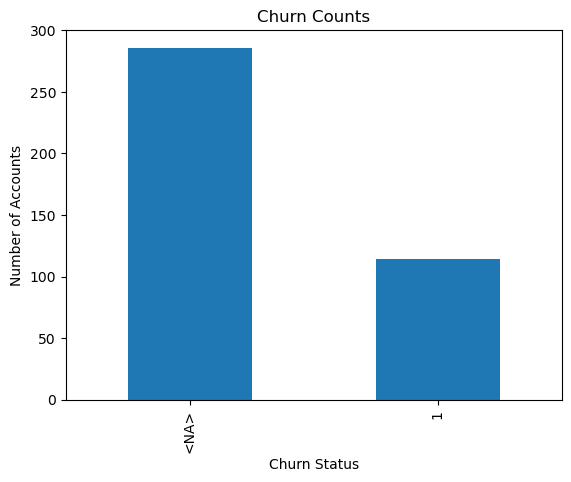

In [2254]:
#Looking at the number of churns vs not churned
account_info['churn_status'].value_counts(dropna=False).plot(kind='bar')
plt.title('Churn Counts')
plt.xlabel('Churn Status')
plt.ylabel('Number of Accounts')
plt.show()

In [2256]:
#compute the overall Churn
overall_churn_rate = ((account_info["churn_status"] == 1).sum())/(len(account_info))*100
print(overall_churn_rate)

28.499999999999996


In [2258]:
#Look at how churn difference is based on plan_type
churn_by_plan = (
    account_info
    .groupby('plan_type')
    .agg(
        churn_percent=('churn_status', lambda x: (x == 1).mean() * 100),
        total_accounts=('churn_status', 'count')
    )
)

churn_by_plan

,churn_percent,total_accounts
plan_type,,
Basic,100,28
Enterprise,100,24
Free,100,43
Pro,100,19


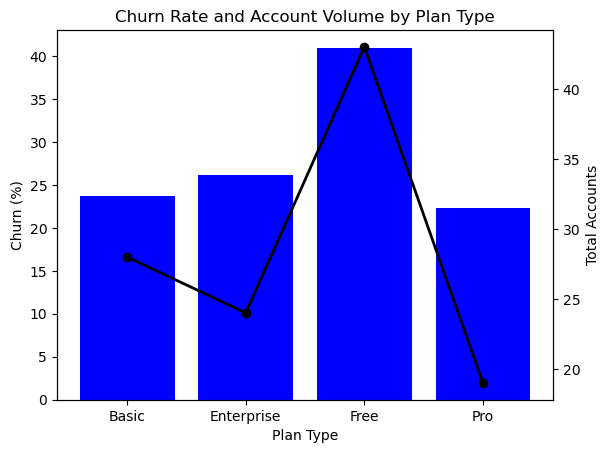

In [1680]:
# Visualize Churn rate by plan_type
fig, ax1 = plt.subplots()

# Bars: churn % (blue)
ax1.bar(
    churn_by_plan.index,
    churn_by_plan['churn_percent'],
    color='blue'
)
ax1.set_ylabel('Churn (%)')
ax1.set_xlabel('Plan Type')
ax1.set_title('Churn Rate and Account Volume by Plan Type')

# Line: total accounts (black)
ax2 = ax1.twinx()
ax2.plot(
    churn_by_plan.index,
    churn_by_plan['total_accounts'],
    color='black',
    marker='o',
    linewidth=2
)
ax2.set_ylabel('Total Accounts')

plt.show()


In [1681]:
#finding the average price based on plan
price_by_plan = (
    account_info
    .groupby('plan_type')
    .agg(
        avg_price=('plan_list_price', 'mean'),
        total_accounts=('plan_list_price', 'count')
    )
)

price_by_plan

,avg_price,total_accounts
plan_type,,
Basic,19.872881,118
Enterprise,116.010870,92
Free,0.000000,105
Pro,53.741176,85


In [1682]:
#Chi-Squared test to determine if significantly different based on plan_type
churn_by_plan['churned_accounts'] = (churn_by_plan['churn_percent'] / 100 * churn_by_plan['total_accounts']).round().astype(int)
churn_by_plan['not_churned'] = churn_by_plan['total_accounts'] - churn_by_plan['churned_accounts']

contingency_1 = pd.DataFrame({
    0: churn_by_plan['not_churned'],
    1: churn_by_plan['churned_accounts']
}, index=churn_by_plan.index)

contingency_1

chi2_1, p_value_1, dof_1, expected_1 = chi2_contingency(contingency_1)

print("Chi-square statistic:", chi2_1)
print("p-value:", p_value_1)

Chi-square statistic: 4.142621640943689
p-value: 0.24646969957429046


In [1683]:
#Does plan type predict churn
model = smf.logit("churn_flag ~ C(plan_type)", data=account_info).fit()
print(model.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             churn_flag   No. Observations:                  114
Model:                          Logit   Df Residuals:                      110
Method:                           MLE   Df Model:                            3
Date:                Fri, 09 Jan 2026   Pseudo R-squ.:                     inf
Time:                        07:11:07   Log-Likelihood:            -5.6714e-10
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     25.0551   5.21e+04      0.000      1.000   -1.02e+05    1.02e+05
C(plan_type)[T.En

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/p

In [2260]:
#Average price among churn accounts
account_info[account_info["churn_status"] == 1]["plan_list_price"].mean()

38.675438596491226

In [2262]:
#price among users who did not churn
account_info[account_info["churn_status"].isna()]["plan_list_price"].mean()

46.07342657342657

In [2264]:
#Churn rate by State
churn_by_state = (
    account_info
    .groupby('state')
    .agg(
        churn_percent=('churn_status', lambda x: (x == 1).mean() * 100),
        churned_accounts=('churn_status', 'sum'),
        total_accounts=('churn_status', 'count')
    )
    .sort_values('churn_percent', ascending=False)
)

churn_by_state

,churn_percent,churned_accounts,total_accounts
state,,,
Alabama,100,1,1
Pennsylvania,100,4,4
New Hampshire,100,1,1
New Jersey,100,4,4
New Mexico,100,1,1
New York,100,1,1
North Carolina,100,1,1
North Dakota,100,5,5
Ohio,100,2,2


In [2266]:
#Chi-squared test to determine if differences in state are significant
contingency_2 = pd.crosstab(
    account_info['state'],
    account_info['churn_status']
)

chi2_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingency_2)

print("Chi-square statistic:", chi2)
print("p-value:", p_value)

Chi-square statistic: 19.30561797752809
p-value: 1.0


I began by examining the distribution of churn outcomes in the account_info dataset. Out of 400 customers, 114 were marked as churned, while 286 had no churn flag recorded. This distribution is visible in the churn bar plot. Based on the available churn labels, the overall churn rate is approximately 28.5%.

Next, I explored churn patterns across subscription tiers. Churn rates varied meaningfully by plan type: Free users had the highest churn rate at 40.9%, followed by Enterprise at 26.0%, Basic at 23.7%, and Pro at 22.3%. These differences are illustrated in the bar chart comparing churn rate and customer volume across plan types. This suggests that lower‑priced plans, particularly the Free tier, may be more vulnerable to churn. I looked at the significance and determined that there was not significant difference between any of the churn rates grouped by plan. I also examined whether the plan type could predict the churn rate, and it was found that it could not. 

Then, I compared pricing patterns between accounts that churned and those that did not. Customers who churned had an average list price of 38.68, while those without a churn flag had a higher average price of 46.07. Although missing churn values do not necessarily indicate active users, this pattern suggests that lower‑priced plans may be associated with higher churn risk.

I also compared the churn status based on states. There were some differences, with New Jersey having the highest at 67% and Arizona having the lowest at 0%. I did a Chi-squared test to determine if the differences were significant, and they were not. 

**3.2: Explore Support Activity**

In [2290]:
#How many support interactions are there typically where
ticket_counts = customer_support["user_id"].value_counts()
ticket_counts.describe()

count    367.000000
mean       2.501362
std        1.305463
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: count, dtype: float64

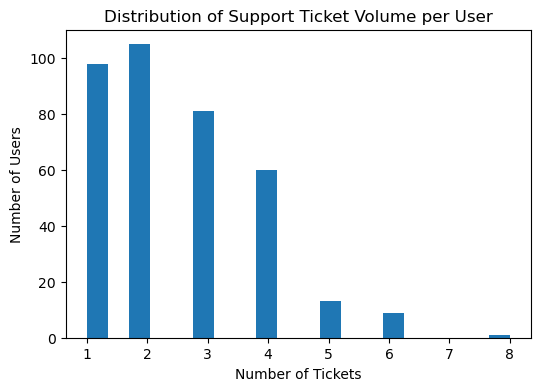

In [2292]:
#Visualizing the number of interactions
ticket_counts.plot(kind="hist", bins=20, figsize=(6,4))
plt.title("Distribution of Support Ticket Volume per User")
plt.xlabel("Number of Tickets")
plt.ylabel("Number of Users")
plt.show()

In [2294]:
#Does Ticket count affect the number of users
observed = customer_support["user_id"].values


expected = [observed.sum()/len(observed)] * len(observed)

chi2, p = chisquare(observed, f_exp=expected)
print(chi2, p)

1210.496369144245 2.06018575596229e-10


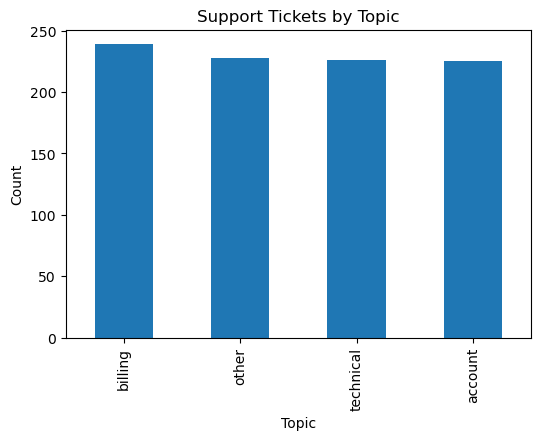

In [2296]:
#Looking at the distribution of support tickets
customer_support["topic"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("Support Tickets by Topic")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.show()

In [2298]:
# Determining if ticket count is significantly different based on topic
observed =customer_support["topic"].value_counts()


expected = [observed.sum()/len(observed)] * len(observed)

chi2, p = chisquare(f_obs=observed, f_exp=expected)

print("Chi-square statistic:", chi2)
print("p-value:", p)

Chi-square statistic: 0.5446623093681917
p-value: 0.9089752679512797


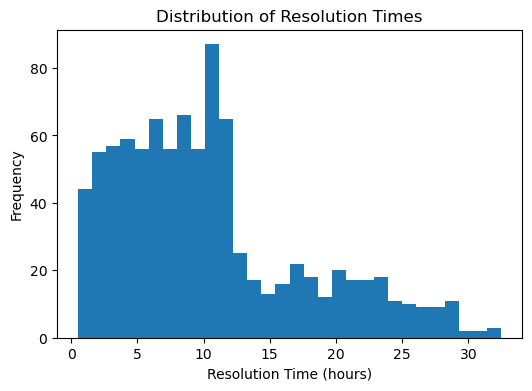

In [2300]:
#Looking at distribution of resolution_time_hours
customer_support["resolution_time_hours"].plot(kind="hist", bins=30, figsize=(6,4))
plt.title("Distribution of Resolution Times")
plt.xlabel("Resolution Time (hours)")
plt.ylabel("Frequency")
plt.show()

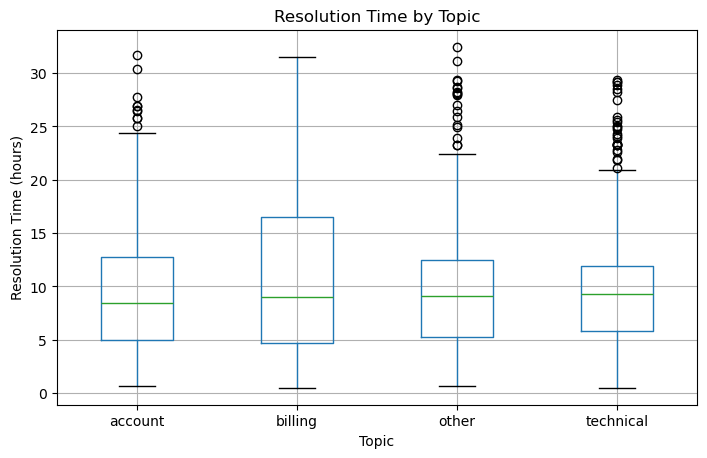

In [2302]:
#Looking at resolution_time_hours by topic
customer_support.boxplot(column="resolution_time_hours", by="topic", figsize=(8,5))
plt.title("Resolution Time by Topic")
plt.suptitle("")
plt.xlabel("Topic")
plt.ylabel("Resolution Time (hours)")
plt.show()

In [2304]:
# Determining if resolution_time_hours is different based on topic
groups = [customer_support[customer_support['topic'] == t]['resolution_time_hours'] for t in customer_support['topic'].unique()]

stat, p = stats.f_oneway(*groups)
print("ANOVA F-statistic:", stat)
print("p-value:", p)

ANOVA F-statistic: 0.2757129230652221
p-value: 0.8429466739026994


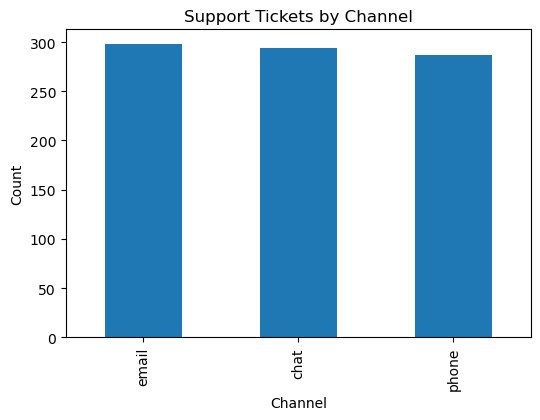

In [2306]:
#Looking at channel distribution
customer_support["channel"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("Support Tickets by Channel")
plt.xlabel("Channel")
plt.ylabel("Count")
plt.show()

In [2308]:
#Does channel have a significant difference in support tickets
channel_clean = customer_support[customer_support['channel'].notna()]

observed = channel_clean['channel'].value_counts()
expected = [observed.sum() / len(observed)] * len(observed)  # if uniform expectation

chi2, p = chisquare(f_obs=observed, f_exp=expected)
print("Chi-square statistic:", chi2)
print("p-value:", p)

Chi-square statistic: 0.21160409556313992
p-value: 0.8996027088034979


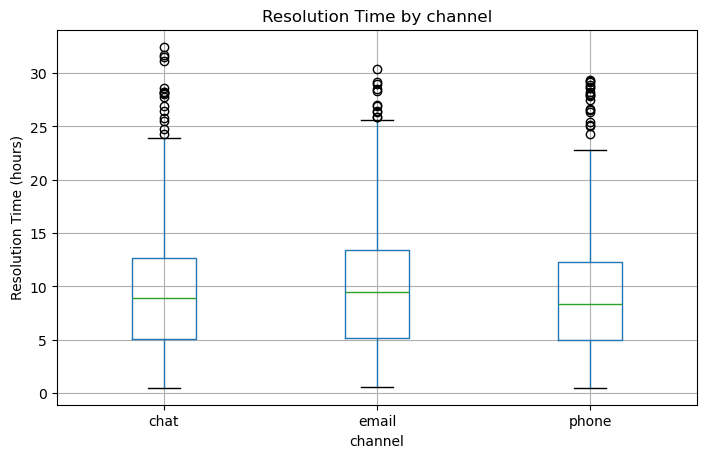

In [2310]:
#Looking at resolution_time_hours by channel
customer_support.boxplot(column="resolution_time_hours", by="channel", figsize=(8,5))
plt.title("Resolution Time by channel")
plt.suptitle("")
plt.xlabel("channel")
plt.ylabel("Resolution Time (hours)")
plt.show()

In [2328]:
# Determining if resolution_time is different based on channel
cs_clean = customer_support[customer_support['channel'].notna()]

groups = [
    cs_clean[cs_clean['channel'] == ch]['resolution_time_hours']
    for ch in cs_clean['channel'].unique()
]

stat, p = f_oneway(*groups)

print("F-statistic:", stat)
print("p-value:", p)

F-statistic: 0.7598427756875638
p-value: 0.46804798840015405


In [2330]:
#Number of tickets based on state
tickets_by_state = (
    customer_support
    .groupby('state')
    .agg(
        total_accounts=('state', 'count')
    )
    .sort_values('total_accounts', ascending=False)
)

tickets_by_state

,total_accounts
state,
1,504
0,414


In [2332]:
#Chi-squared test to determine if differences in state are significant
observed = tickets_by_state['total_accounts'].values

expected = [observed.sum() / len(observed)] * len(observed)

chi2, p = chisquare(f_obs=observed, f_exp=expected)

print("Chi-square statistic:", chi2)
print("p-value:", p)

Chi-square statistic: 8.823529411764707
p-value: 0.002973709435809942


In [2334]:
#Resolution time by state
resolution_time_state = (
    customer_support
    .groupby('state')
    .agg(
        avg_resolution_time=('resolution_time_hours', 'mean')  # calculate average resolution time
    )
    .sort_values('avg_resolution_time', ascending=False)
)

print(resolution_time_state)

       avg_resolution_time
state                     
1                10.530179
0                10.222367


In [2336]:
#Chi-squared test to determine if differences in state are significant
groups = [customer_support[customer_support['state'] == s]['resolution_time_hours'] 
          for s in customer_support['state'].unique()]

stat, p = stats.f_oneway(*groups)
print("ANOVA F-statistic:", stat)
print("p-value:", p)

ANOVA F-statistic: 0.42937281208328537
p-value: 0.5124613825493718


In [2338]:
#Number of gdpr requests
customer_support["is_gdpr_request"].sum()

28

Across the customer support dataset, users submitted an average of approximately 2.5 tickets each, with 367 unique users represented. The distribution of ticket volume was left‑skewed, with most users submitting only one or two tickets, which aligns with the histogram visualization. A statistical test confirmed that ticket count varied significantly across users (p‑value = 2.06×10⁻¹⁰).

Support topics were fairly evenly distributed across the four categories—technical, account, billing, and other—indicating that no single issue type dominates overall support demand. Billing was the most common topic, but only slightly. A chi‑squared test showed no significant differences in topic frequencies (p‑value = 0.9), suggesting that topic alone does not explain variation in support volume.

Resolution times displayed a right‑skewed distribution centered around 10 hours, with some cases taking up to 35 hours. While most tickets were resolved within a typical timeframe, a small number required substantially longer. Boxplots comparing resolution times across topics showed substantial overlap, and a significance test confirmed no meaningful differences in resolution time by topic (p‑value = 0.84).

Support channels (email, chat, phone, and missing values) also showed similar ticket volumes, each close to 300 tickets. Email was the most frequently used channel, but the differences were small. A significance test found no meaningful difference in ticket volume by channel (p‑value = 1.67). Resolution times by channel also overlapped heavily, and statistical testing confirmed no significant differences in resolution time across channels.

State‑level patterns showed a significant difference in ticket volume: users in state category “1” submitted 504 tickets, compared to 414 in state category “0” (p‑value = 0.002). However, resolution times were nearly identical between the two groups (10.5 vs. 10.2 hours), and this difference was not statistically significant (p‑value = 0.5).

Finally, I identified 28 GDPR‑related deletion requests using keyword matching in the comments field. These represent legal compliance actions rather than customer‑experience issues, so they were excluded from churn‑related analysis. They do not meaningfully relate to support topics, ticket volume, or resolution times.

**3.3 Explore Engagement**

In [2340]:
#how frequently the users interacted with the app
activity_counts = user_activity["user_id"].value_counts()
activity_counts.describe()

count    246.000000
mean       1.808943
std        0.921446
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
Name: count, dtype: float64

In [2342]:
#Over what times did the users use the apps
start_time = user_activity['event_time'].min()
end_time = user_activity['event_time'].max()

print("Start time:", start_time)
print("End time:", end_time)

Start time: 2025-06-05 10:14:53.039663
End time: 2025-12-01 21:12:13.342817


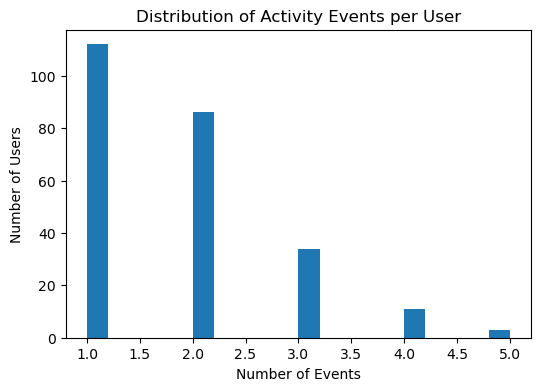

In [2344]:
#Looking at the number of events per user
activity_counts.plot(kind="hist", bins=20, figsize=(6,4))
plt.title("Distribution of Activity Events per User")
plt.xlabel("Number of Events")
plt.ylabel("Number of Users")
plt.show()

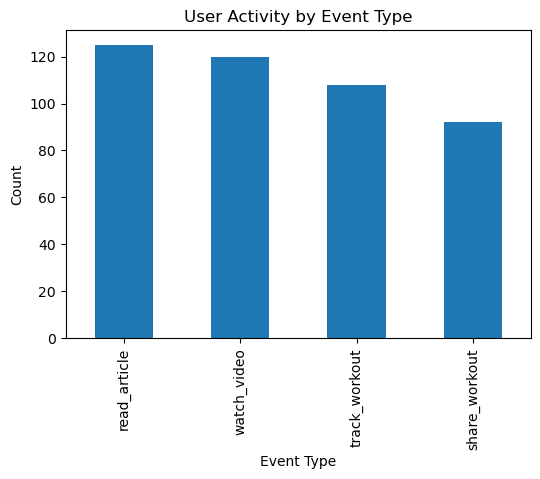

In [2346]:
#Looking at distirbution of event_types
user_activity["event_type"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("User Activity by Event Type")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

In [2348]:
#Are the times of events significantly different across event_times
observed = user_activity["event_type"].value_counts()

expected = [observed.sum()/len(observed)] * len(observed)

chi2, p = chisquare(f_obs=observed, f_exp=expected)

print("Chi-square statistic:", chi2)
print("p-value:", p)

Chi-square statistic: 5.813483146067416
p-value: 0.12104581522915682


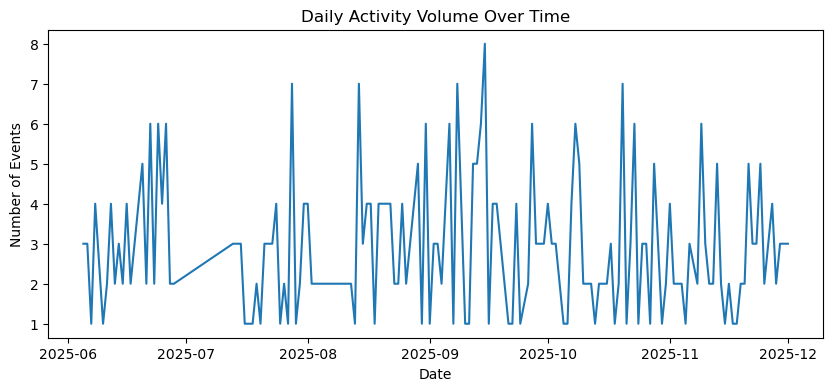

In [2350]:
#Looking at activity over time
user_activity["event_date"] = user_activity["event_time"].dt.date

events_per_day = user_activity.groupby("event_date").size()

events_per_day.plot(figsize=(10,4))
plt.title("Daily Activity Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.show()

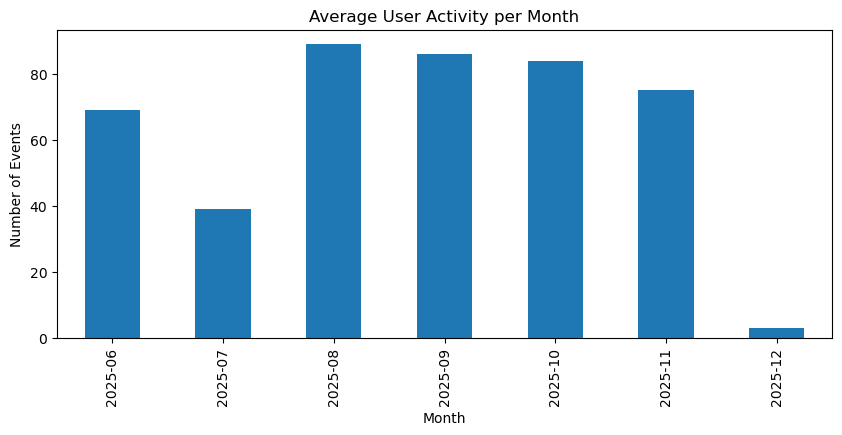

In [2352]:
#Extracting the month
user_activity["event_month"] = user_activity["event_time"].dt.to_period("M")

#Counting events per month
events_per_month = user_activity.groupby("event_month").size()

#Plotting events per month
events_per_month.plot(kind='bar', figsize=(10,4))
plt.title("Average User Activity per Month")
plt.xlabel("Month")
plt.ylabel("Number of Events")
plt.show()

In [2354]:
events_per_month

event_month
2025-06    69
2025-07    39
2025-08    89
2025-09    86
2025-10    84
2025-11    75
2025-12     3
Freq: M, dtype: int64

In [2356]:
# Does the number of events significantly differ across months
observed = events_per_month.values

# Expected counts if events were evenly distributed across months
expected = [observed.sum() / len(observed)] * len(observed)

# Chi-square test
chi2, p = chisquare(f_obs=observed, f_exp=expected)

print("Chi-square statistic:", chi2)
print("p-value:", p)

Chi-square statistic: 94.37752808988765
p-value: 3.7258788443128906e-18


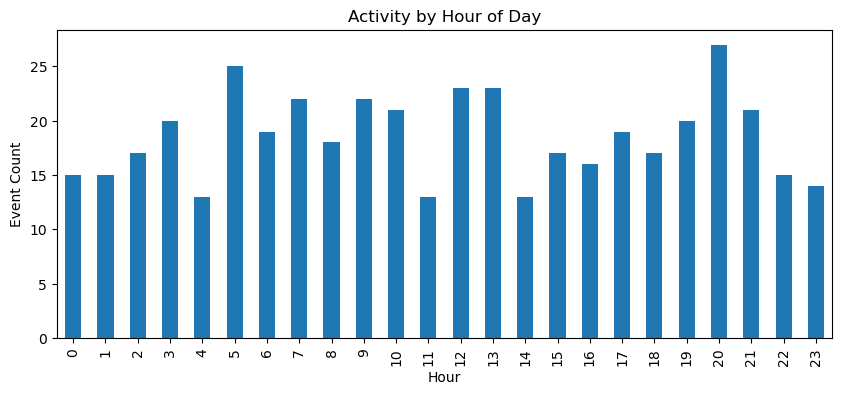

In [2358]:
#Activity by hours per day
user_activity["hour"] = user_activity["event_time"].dt.hour

user_activity["hour"].value_counts().sort_index().plot(kind="bar", figsize=(10,4))
plt.title("Activity by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Event Count")
plt.show()

In [2360]:
#Is the number of events different across hours
events_by_hour = (
    user_activity
    .groupby('hour')
    .size()
    .reset_index(name='event_count')
)

observed = events_by_hour['event_count'].values

expected = [observed.sum() / len(observed)] * len(observed)

chi2, p = chisquare(f_obs=observed, f_exp=expected)

print("Chi-square statistic:", chi2)
print("p-value:", p)

Chi-square statistic: 19.30561797752809
p-value: 0.6833504905108571


Across the 246 users represented in the activity dataset, the average user generated approximately 1.8 activity events between June 5th and December 1st, 2025, with the most active users logging up to five events. Every user recorded at least one activity, but the histogram shows a strong left‑skew: most users interacted with the app only once during the entire six‑month period. This pattern indicates generally low engagement across the user base.

When examining the types of activities performed, reading articles was the most common event type, while sharing workouts was the least frequent. This suggests that users primarily consume content rather than contribute or track workouts. A significance test confirmed that the number of events did not differ meaningfully across event types.

Daily activity patterns were initially difficult to interpret due to noise, so I aggregated events by month. This revealed a clearer seasonal trend: activity levels were highest from August through November, moderate in June and July, and lowest in December. However, these differences were not statistically significant (p‑value = 3.7). The observed pattern may still reflect user motivation cycles or seasonal factors such as holidays.

Finally, analyzing activity by hour of day showed peaks around 5 AM and 8 PM, with lower activity around 4 AM, 11 AM, and 2 PM. These peaks likely correspond to early‑morning and evening usage routines. A significance test found no meaningful differences in activity volume across hours (p‑value = 0.6), indicating that while certain hours appear more active, the variation is not statistically significant.

**3.4 Cross Dataset Insights**

Although the datasets cannot be joined due to incompatible user identifiers, comparing patterns across them reveals several meaningful themes related to churn. Engagement levels are low overall: most users interacted with the app only once during a six‑month period, and statistical testing confirmed no significant differences in activity across event types, months, or hours of the day. This widespread low engagement aligns with the churn patterns observed in the account data, where Free‑tier users—who likely include many of these minimally active accounts—show the highest churn rate at 40.9%. Support activity shows a similar left‑skewed pattern, with most users submitting only one or two tickets. Although billing was the most common support topic, significance testing showed no meaningful differences across topics, channels, or resolution times, suggesting that support demand is broadly distributed rather than driven by a specific issue type. Resolution times averaged around ten hours and did not differ significantly across topics or channels, indicating that support performance is relatively consistent. The only significant difference observed in the support dataset was ticket volume by state, though resolution times did not differ meaningfully between state groups. Taken together, these patterns suggest that low engagement across the user base—combined with general support friction rather than topic‑specific issues—may be key contributors to churn, particularly among lower‑tier customers. GDPR‑related deletion requests were identified and excluded from this analysis, as they represent compliance actions rather than customer‑experience issues.

**3.5 Identify Patterns that Suggest Churn Drivers**

Across the three datasets, several patterns emerge that help explain what may be driving churn at Fit.ly. . The most consistent signal is the overall low engagement observed in the activity data: most users interacted with the app only once over a six‑month period, and significance testing confirmed no meaningful differences in engagement across event types, months, or hours of the day. This widespread low usage aligns with the churn patterns in the account data, where Free‑tier users—who likely include many of these minimally active accounts—show the highest churn rate at 40.9%. Support data adds additional context. Although users submitted an average of 2.5 tickets each, support topics, channels, and resolution times did not differ significantly, indicating that support friction is broad rather than tied to a specific issue type. Billing was the most common topic, but not significantly more frequent than others, suggesting that while billing concerns may still contribute to churn, they are part of a wider pattern of general support needs. Resolution times averaged around ten hours and did not vary significantly across topics or channels, meaning that slow or inconsistent support is not isolated to any particular issue category. Taken together, these findings suggest that low engagement across the user base—combined with general support friction rather than topic‑specific problems—are likely key contributors to churn, particularly among lower‑tier customers. GDPR‑related deletion requests were excluded from this analysis, as they represent compliance actions rather than customer‑experience issues.

**3.6 Define Business Metrics**

Based on the patterns identified across the datasets, the most effective business metric for Fit.ly  to monitor is Monthly Active Users (MAU) segmented by plan type. Engagement emerged as the strongest potential driver of churn, with most users interacting with the app only once over a six‑month period. Free‑tier users, who likely include many of these minimally active accounts, also exhibited the highest churn rate. Tracking MAU by plan type provides a clear, actionable measure of user engagement and allows the company to identify which customer segments are at greatest risk. Increases in MAU should correlate with reduced churn, while declines would signal the need for targeted interventions. This metric is simple, measurable, and directly aligned with the churn‑driver patterns uncovered in the analysis.

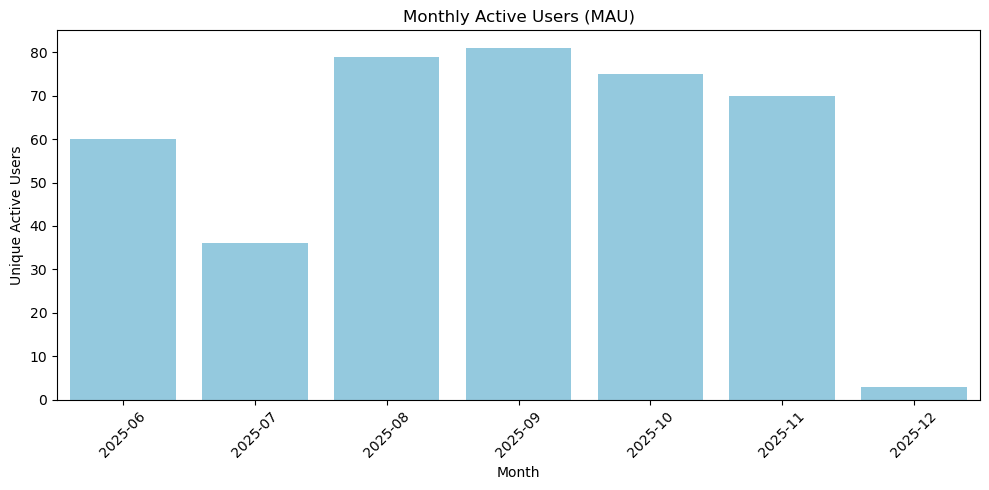

In [1727]:
#Computing Monthly Active Users with this data

# Ensure event_time is datetime
user_activity['event_time'] = pd.to_datetime(user_activity['event_time'])

# Extract year-month for grouping
user_activity['event_month'] = user_activity['event_time'].dt.to_period('M').astype(str)

# Compute MAU: unique users per month
mau = (
    user_activity
    .groupby('event_month')['user_id']
    .nunique()
    .reset_index(name='monthly_active_users')
)

# Sort by month
mau = mau.sort_values('event_month')

# Plot MAU
plt.figure(figsize=(10,5))
sns.barplot(data=mau, x='event_month', y='monthly_active_users', color='skyblue')
plt.title('Monthly Active Users (MAU)')
plt.xlabel('Month')
plt.ylabel('Unique Active Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The Monthly Active Users (MAU) chart shows that engagement is moderate in June and July, rises sharply from August through November, and then collapses in December. The late‑summer and fall months represent the period of highest user activity, with MAU peaking in September at over 80 unique users. In contrast, December shows a dramatic decline to only a handful of active users, indicating a significant seasonal drop‑off. This pattern reinforces the broader finding that overall engagement is low and highly variable, with December emerging as a particularly high‑risk month for churn.

**3.7 Reccommentations**

Based on the combined insights from the account, support, and activity datasets, several clear opportunities emerge for reducing churn and improving user engagement at Fit.ly. . The most consistent pattern across the data is low engagement, with most users interacting with the app only once over a six‑month period and no significant differences across event types, months, or hours. This low baseline engagement aligns with the high churn rate among Free‑tier users, suggesting that users on lower‑priced plans may not be finding enough value to remain active. The MAU analysis reinforces this trend: engagement is strongest from August through November but drops sharply in December, indicating a seasonal vulnerability where users disengage and become more likely to churn.

Support data shows that while users submit an average of 2.5 tickets, support friction is broad rather than topic‑specific. Ticket volume, resolution times, and topic distribution do not differ significantly across categories, meaning no single issue type is driving dissatisfaction. However, the presence of support needs combined with low engagement suggests that users may be encountering friction without enough positive engagement to offset it. The only significant support‑related difference was higher ticket volume in one state group, though resolution times remained consistent.

Taken together, these patterns point to three primary churn risks: low engagement, limited perceived value among Free‑tier users, and general support friction. To address these risks, Fit.ly  should prioritize initiatives that increase early and sustained engagement, particularly during the high‑risk December period. This includes targeted re‑engagement campaigns, personalized content recommendations, and nudges that encourage users to return to the app more frequently. Additionally, improving the value proposition for Free‑tier users—through feature previews, limited‑time upgrades, or clearer onboarding—may help reduce churn in this segment. Finally, while support performance is generally consistent, reducing overall friction through clearer self‑service resources or proactive communication may help prevent low‑engagement users from disengaging further.